In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

import random
import numpy as np
import torch
torch.backends.cudnn.benchmark = True

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    NormalizeIntensityd,
    GaussianSmoothd,
    ScaleIntensityd,
    RandSpatialCropd,
    RandGaussianNoised,
    ToTensord,
    RandCropByLabelClassesd,
    RandCropd,
    RandGaussianSmoothd,
    CastToTyped
)
from monai.networks.layers.factories import Act, Norm
from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNet

from src.models import UNet_CBAM

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

# 랜덤 시드 고정
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


print_config()

import torch.nn as nn
import torch.nn.functional as F
from monai.losses import TverskyLoss
from src.dataset.dataset import create_dataloaders
from src.dataset.dataset_csv import create_dataloaders_from_csv
from pathlib import Path
import torch.optim as optim

class_info = {
    0: {"name": "background", "weight": 0},  # weight 없음
    1: {"name": "apo-ferritin", "weight": 1000},
    2: {"name": "beta-amylase", "weight": 100}, # 4130
    3: {"name": "beta-galactosidase", "weight": 1500}, #3080
    4: {"name": "ribosome", "weight": 1000},
    5: {"name": "thyroglobulin", "weight": 1500},
    6: {"name": "virus-like-particle", "weight": 1000},
}

# 가중치에 비례한 비율 계산
raw_ratios = {
    k: (v["weight"] if v["weight"] is not None else 0.01)  # 가중치 비례, None일 경우 기본값a
    for k, v in class_info.items()
}
total = sum(raw_ratios.values())
ratios = {k: v / total for k, v in raw_ratios.items()}

# 최종 합계가 1인지 확인
final_total = sum(ratios.values())
print("클래스 비율:", ratios)
print("최종 합계:", final_total)

# 비율을 리스트로 변환
ratios_list = [ratios[k] for k in sorted(ratios.keys())]
print("클래스 비율 리스트:", ratios_list)

c:\ProgramData\anaconda3\envs\czii\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.4.0
Numpy version: 1.26.3
Pytorch version: 2.5.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: c:\ProgramData\anaconda3\envs\czii\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.0
scipy version: 1.15.1
Pillow version: 10.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.20.1+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.1.1
pandas version: 2.2.3
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For d

# Loss function

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from monai.losses import TverskyLoss

# DynamicTverskyLoss 클래스 정의
class DynamicTverskyLoss(TverskyLoss):
    def __init__(self, lamda=0.5, **kwargs):
        super().__init__(alpha=1 - lamda, beta=lamda, **kwargs)
        self.lamda = lamda

    def set_lamda(self, lamda):
        self.lamda = lamda
        self.alpha = 1 - lamda
        self.beta = lamda


# CombinedCETverskyLoss 클래스
class CombinedCETverskyLoss(nn.Module):
    def __init__(self, lamda=0.5, ce_weight=0.5, n_classes=7, class_weights=None, ignore_index=-1, **kwargs):
        super().__init__()
        self.n_classes = n_classes
        self.ce_weight = ce_weight
        self.ignore_index = ignore_index
        
        # CrossEntropyLoss에서 클래스별 가중치를 적용
        self.ce = nn.CrossEntropyLoss(weight=class_weights, ignore_index=self.ignore_index, reduction='mean', **kwargs)
        
        # TverskyLoss
        self.tversky = DynamicTverskyLoss(lamda=lamda, reduction="mean",softmax=True, **kwargs)

    def forward(self, inputs, targets):
        
        # CrossEntropyLoss는 정수형 클래스 인덱스를 사용
        ce_loss = self.ce(inputs, targets)

        # TverskyLoss 계산 (원핫 인코딩된 라벨을 사용)
        
        tversky_loss = self.tversky(inputs, targets)

        # 최종 손실 계산
        final_loss = self.ce_weight * ce_loss + (1 - self.ce_weight) * tversky_loss
        return final_loss

    def set_lamda(self, lamda):
        self.tversky.set_lamda(lamda)

    @property
    def lamda(self):
        return self.tversky.lamda

In [3]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Dict, Optional, Tuple, Sequence

# -----------------------------------------------------------------------------------
# 0) DFLoss (분포 기반 좌표 학습)
# -----------------------------------------------------------------------------------
class DFLoss(nn.Module):
    """
    DFL (Distribution Focal Loss), 좌표 offset을 0~reg_max 범위로 보고,
    floor와 floor+1 bin 사이를 나누어 CrossEntropy를 계산하는 방식.
    """
    def __init__(self, reg_max=16) -> None:
        super().__init__()
        self.reg_max = reg_max

    def forward(self, pred_dist: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        pred_dist: (N, reg_max)  # 각 coordinate별 reg_max 로짓
        target: (N,)  # 실값 (0 <= t < reg_max)
        
        return: (N,) shape의 loss (coordinate별)
        """
        # clamp to valid range (ex: 0 ~ reg_max-1)
        target = target.clamp_(0, self.reg_max - 1 - 0.01)

        tl = target.long()       # floor index
        tr = tl + 1              # floor+1
        wl = tr - target         # weight for left bin
        wr = 1 - wl              # weight for right bin

        # Cross Entropy를 각각 bin에 대해 계산
        # pred_dist.shape = (N, reg_max)
        # CE에는 레이블이 정수여야 하므로, tl, tr 둘을 이용해 2번 계산
        loss_l = F.cross_entropy(pred_dist, tl, reduction="none") * wl
        # tr이 reg_max를 넘어갈 수 있으므로 clamp
        tr = tr.clamp(max=self.reg_max - 1)
        loss_r = F.cross_entropy(pred_dist, tr, reduction="none") * wr

        # 두 bin 손실 합산
        loss = loss_l + loss_r  # (N,)
        return loss


# ------------------------- Fixed Sphere IoU Functions -------------------------
def sphere_intersection_volume(r1: torch.Tensor, r2: torch.Tensor, d: torch.Tensor) -> torch.Tensor:
    """
    두 구(반지름 r1, r2), 중심 거리 d에서 교집합 부피를 반환.
    r1, r2, d는 동일한 shape를 가져야 함.
    """
    no_overlap = (d >= (r1 + r2))
    contained = (d <= (r1 - r2).abs())
    
    inter_vol = torch.zeros_like(d)
    v1 = (4.0 / 3.0) * math.pi * (r1 ** 3)
    v2 = (4.0 / 3.0) * math.pi * (r2 ** 3)
    
    # Case 1: 완전히 포함
    inside_mask = contained & (~no_overlap)
    inter_vol[inside_mask] = torch.min(v1[inside_mask], v2[inside_mask])
    
    # Case 2: 부분 교차
    partial = ~(no_overlap | contained)
    if partial.any():
        dp = d[partial]
        r1p = r1[partial]
        r2p = r2[partial]
        term = (r1p + r2p - dp) ** 2
        numerator = math.pi * term * (dp ** 2 + 2 * dp * (r1p + r2p) - 3 * (r1p ** 2 + r2p ** 2) + 6 * r1p * r2p)
        vol = numerator / (12.0 * dp + 1e-9)
        vol = torch.clamp_min(vol, 0.)
        inter_vol[partial] = vol
    
    return inter_vol

def sphere_iou(sphere1: torch.Tensor, sphere2: torch.Tensor) -> torch.Tensor:
    """
    sphere1: (N, 4) (x, y, z, r)
    sphere2: (M, 4) (x, y, z, r)
    return: IoU (N, M)
    """
    c1, r1 = sphere1[..., :3], sphere1[..., 3].clamp_min(1e-6)  # 반경이 0이 되지 않도록 방지
    c2, r2 = sphere2[..., :3], sphere2[..., 3].clamp_min(1e-6)

    d = torch.norm(c1 - c2, dim=-1)  # (...,)

    # 반경이 d와 동일한 shape으로 브로드캐스팅되도록 처리
    if r1.dim() < d.dim():
        r1 = r1.unsqueeze(-1)
    if r2.dim() < d.dim():
        r2 = r2.unsqueeze(-1)
    r1 = r1.expand_as(d)
    r2 = r2.expand_as(d)

    # 교집합 볼륨 계산
    inter_vol = sphere_intersection_volume(r1, r2, d)

    # 개별 구의 볼륨
    v1 = (4.0 / 3.0) * math.pi * (r1 ** 3)
    v2 = (4.0 / 3.0) * math.pi * (r2 ** 3)

    # 합집합 볼륨
    union_vol = v1 + v2 - inter_vol

    # NaN 방지 (union_vol이 0이 되는 경우를 방지)
    return inter_vol / (union_vol + 1e-6)




# -----------------------------------------------------------------------------------
# 2) dist2sphere (DFL -> (x,y,z,r)) 함수
# -----------------------------------------------------------------------------------
def dist2sphere(pred_dist: torch.Tensor, anchors_3d: torch.Tensor, reg_max: int):
    """
    pred_dist: (B, A, 4*reg_max) => 4 coords * reg_max bins
    anchors_3d: (B, A, 3) or (A,3)
    return: (B, A, 4) => (x, y, z, r)
    """
    B, A, C = pred_dist.shape
    assert C == 4 * reg_max, f"pred_dist shape mismatch: {C} vs 4*{reg_max}"

    dist_4d = pred_dist.view(B, A, 4, reg_max)  # (B,A,4,reg_max)
    dist_prob = F.softmax(dist_4d, dim=3)       # (B,A,4,reg_max)
    bin_index = torch.arange(reg_max, device=pred_dist.device, dtype=pred_dist.dtype)
    dist_val = (dist_prob * bin_index).sum(dim=3)  # (B,A,4)

    # anchors_3d shape = (B,A,3) or broadcast
    xyz = anchors_3d[..., :3] + dist_val[..., :3]
    r   = dist_val[..., 3:].clamp_min(0.)
    return torch.cat([xyz, r], dim=-1)  # (B,A,4)


# -----------------------------------------------------------------------------------
# 3) 개선된 TaskAlignedAssigner3D (margin 적용)
# -----------------------------------------------------------------------------------
def select_candidates_in_spheres(
    anc_points: torch.Tensor,
    gt_spheres: torch.Tensor,
    margin_factor: float = 0.1
) -> torch.Tensor:
    """
    anchor center가 구 중심에서 거리 <= (r * (1 + margin_factor)) 이면 candidate
    anc_points: (n_anchors, 3) 또는 (B, n_anchors, 3)
    gt_spheres: (B, n_max_boxes, 4)
    returns: (B, n_max_boxes, n_anchors) bool/float
    """
    B, n_g, _ = gt_spheres.shape
    n_anchors = anc_points.shape[0]

    if n_g == 0:
        return torch.zeros((B, 0, n_anchors), device=anc_points.device)  # GT가 없을 때 예외 처리

    centers = gt_spheres[..., :3]  # (B, n_g, 3)
    radii = gt_spheres[..., 3].clamp_min(0.)  # (B, n_g)

    # 차원 확장
    cent_3d = centers.unsqueeze(2)  # (B, n_g, 1, 3)

    if anc_points.dim() == 2:
        anc_3d = anc_points.unsqueeze(0).unsqueeze(0)  # (1, 1, nA, 3)
    else:
        anc_3d = anc_points.unsqueeze(1)  # (B, 1, nA, 3)

    d = (anc_3d - cent_3d).pow(2).sum(-1).sqrt()  # (B, n_g, nA)
    r_expanded = radii.unsqueeze(-1) * (1.0 + margin_factor)  # (B, n_g, 1)
    mask = (d <= r_expanded)

    return mask.float()


import torch
import torch.nn as nn
from typing import Optional

class TaskAlignedAssigner3D(nn.Module):
    """
    A task-aligned assigner for 3D sphere detection.
    Combine cls^alpha * IoU^beta, pick top-k anchors for each GT,
    handle multi-assign by picking the GT with highest IoU for that anchor.
    """

    def __init__(
        self,
        topk=30,
        num_classes=1,
        alpha=1.0,
        beta=6.0,
        iou_weight=3.0,
        cls_weight=1.0,
        margin_factor=0.2,
        eps=1e-9
    ):
        super().__init__()
        self.topk = topk
        self.num_classes = num_classes
        self.alpha = alpha
        self.beta = beta
        self.iou_weight = iou_weight
        self.cls_weight = cls_weight
        self.margin_factor = margin_factor
        self.eps = eps

    @torch.no_grad()
    def assign(
        self,
        pd_scores: torch.Tensor,    # (B, A, nc) raw cls logits
        pd_spheres: torch.Tensor,   # (B, A, 4)
        anc_points: torch.Tensor,   # (A, 3) 실제 anchor center
        gt_spheres: torch.Tensor,   # (B, n_max_boxes, 4)
        gt_classes: torch.Tensor,   # (B, n_max_boxes)
    ):
        """
        Returns:
            fg_mask: (B, A) bool
            box_target: (B, A, 4)
            cls_target: (B, A, nc)
        """
        B, A, nc = pd_scores.shape
        n_max_boxes = gt_spheres.shape[1]
        device = pd_scores.device

        if n_max_boxes == 0:
            # no GT
            fg_mask = torch.zeros((B, A), dtype=torch.bool, device=device)
            box_target = torch.zeros((B, A, 4), device=device)
            cls_target = torch.zeros((B, A, nc), device=device)
            return fg_mask, box_target, cls_target

        # 1) select_candidates_in_spheres => margin_factor 적용
        #    anc_points: (A,3), gt_spheres: (B, n_max, 4)
        mask_in_spheres = select_candidates_in_spheres(
            anc_points, gt_spheres, margin_factor=self.margin_factor
        )  # shape (B, n_max, A)

        # 2) compute alignment metric => (cls^alpha * iou^beta)
        align_metric, overlaps = self.get_box_metrics(
            pd_scores, pd_spheres, gt_classes, gt_spheres, mask_in_spheres
        )

        # 3) top-k mask
        mask_topk = self.select_topk_candidates(align_metric, topk_mask=None)
        mask_pos = mask_in_spheres * mask_topk  # (B,n_max,A)

        # 4) select_highest_overlaps => multi-assign 해소
        target_gt_idx, fg_mask, mask_pos = self.select_highest_overlaps(
            mask_pos, overlaps, n_max_boxes
        )
        # 5) get_targets => (cls_target, box_target)
        target_labels, target_spheres, target_scores = self.get_targets(
            gt_classes, gt_spheres, target_gt_idx, fg_mask
        )

        return fg_mask, target_spheres, target_scores

    def get_box_metrics(
        self,
        pd_scores: torch.Tensor,
        pd_spheres: torch.Tensor,
        gt_classes: torch.Tensor,
        gt_spheres: torch.Tensor,
        mask_in_spheres: torch.Tensor
    ):
        """
        overlap => sphere_iou
        cls => pd_scores.sigmoid() for each gt class
        align_metric = cls^alpha * iou^beta
        """
        B, A, nc = pd_scores.shape
        device = pd_scores.device
        n_max_boxes = gt_spheres.shape[1]

        overlaps = torch.zeros((B, n_max_boxes, A), device=device)
        bbox_scores = torch.zeros((B, n_max_boxes, A), device=device, dtype=pd_scores.dtype)

        # compute iou
        for b_i in range(B):
            # pd_spheres[b_i]: (A,4)
            # gt_spheres[b_i]: (n_max_boxes,4)
            # sphere_iou => (A,n_max_boxes)
            ps = pd_spheres[b_i].unsqueeze(1)  # (A,1,4)
            gs = gt_spheres[b_i].unsqueeze(0)  # (1,n_max_boxes,4)
            ious = sphere_iou(ps, gs)          # (A,n_max_boxes)
            overlaps[b_i] = ious.transpose(0,1)  # => (n_max_boxes,A)

        # compute cls score => pd_scores.sigmoid()
        pd_sig = pd_scores.sigmoid()
        for b_i in range(B):
            for g_i in range(n_max_boxes):
                if mask_in_spheres[b_i, g_i].any():
                    cls_idx = int(gt_classes[b_i, g_i].item())
                    if 0 <= cls_idx < nc:
                        # bbox_scores[b_i,g_i,:] = pd_sig[b_i,:, cls_idx]
                        bbox_scores[b_i, g_i] = pd_sig[b_i, :, cls_idx]

        # align_metric
        #   => (cls^alpha) * (iou^beta)
        #   => mask_in_spheres=0 인 곳은 0으로
        align_metric = bbox_scores.pow(self.alpha) * overlaps.pow(self.beta)
        align_metric = align_metric * mask_in_spheres  # outside sphere => 0
        return align_metric, overlaps

    def select_topk_candidates(self, metrics: torch.Tensor, topk_mask: Optional[torch.Tensor]=None, largest=True):
        """
        metrics: (B, n_max_boxes, A)
        => pick top-k anchors per GT box
        return: (B, n_max_boxes, A) mask
        """
        B, n_m, A = metrics.shape
        val, idxs = torch.topk(metrics, self.topk, dim=-1, largest=largest)  # (B,n_m,topk)
        if topk_mask is None:
            topk_mask = (val > self.eps)

        mask = torch.zeros_like(metrics)
        for b_i in range(B):
            for g_i in range(n_m):
                valid_k = topk_mask[b_i, g_i]  # (topk,)
                sel_ind = idxs[b_i, g_i, valid_k]  # anchor indices
                mask[b_i, g_i, sel_ind] = 1.0

        return mask

    def select_highest_overlaps(self, mask_pos, overlaps, n_max_boxes):
        """
        mask_pos: (B, n_max_boxes, A)
        overlaps: (B, n_max_boxes, A)
        => 한 anchor가 여러 GT에 할당된 경우 => overlaps 최대인 GT만
        return:
          target_gt_idx: (B,A)
          fg_mask: (B,A)
          mask_pos => updated
        """
        fg_mask = mask_pos.sum(dim=1)  # (B,A)
        if fg_mask.max() > 1:
            # multi-assign => pick max overlap GT
            max_overlaps_idx = overlaps.argmax(dim=1)  # (B,A)
            new_mask = torch.zeros_like(mask_pos)
            B_, _, A_ = mask_pos.shape
            for b_i in range(B_):
                for a_i in range(A_):
                    g_i = max_overlaps_idx[b_i,a_i]
                    new_mask[b_i, g_i, a_i] = 1.0
            mask_pos = new_mask
            fg_mask = mask_pos.sum(dim=1)

        # target_gt_idx
        target_gt_idx = mask_pos.argmax(dim=1)  # (B,A)
        return target_gt_idx, fg_mask.bool(), mask_pos

    def get_targets(self, gt_classes, gt_spheres, target_gt_idx, fg_mask):
        """
        Return (assigned_labels, assigned_spheres, cls_target)
        """
        B, A = fg_mask.shape
        device = gt_classes.device
        n_max_boxes = gt_spheres.shape[1]

        # gather idx
        batch_ind = torch.arange(B, device=device).view(-1,1).expand(B,A)
        gather_idx = target_gt_idx + batch_ind*n_max_boxes  # (B,A)

        gt_spheres_2d = gt_spheres.view(B*n_max_boxes, 4)
        gt_classes_2d = gt_classes.view(B*n_max_boxes)

        assigned_labels  = gt_classes_2d[gather_idx.reshape(-1)].view(B,A)
        assigned_spheres= gt_spheres_2d[gather_idx.reshape(-1)].view(B,A,4)

        # build cls_target
        nc = self.num_classes
        cls_target = torch.zeros((B, A, nc), device=device)
        for b_i in range(B):
            valid_anchors = fg_mask[b_i].nonzero(as_tuple=True)[0]  # (some_count,)
            for a_i in valid_anchors:
                c_idx = int(assigned_labels[b_i,a_i].item())
                if 0 <= c_idx < nc:
                    cls_target[b_i,a_i,c_idx] = 1.0

        return assigned_labels, assigned_spheres, cls_target



# -----------------------------------------------------------------------------------
# 4) 최종 Loss
# -----------------------------------------------------------------------------------
class YOLOv8SphereLoss3D_Advanced(nn.Module):
    """
    개선된 3D YOLO Loss with:
      - Top-k TaskAlignedAssigner3D (with margin_factor)
      - Sphere IoU
      - Classification (BCE)
      - DFL
    """
    def __init__(
        self,
        num_classes: int = 7,
        reg_max: int = 16,
        iou_weight: float = 3.0,
        cls_weight: float = 1.0,
        dfl_weight: float = 1.0,
        topk: int = 30,
        alpha: float = 1.0,
        beta: float = 6.0,
        margin_factor: float = 0.1,
        device: str = "cuda",
    ):
        super().__init__()
        self.num_classes = num_classes
        self.reg_max = reg_max
        self.iou_weight = iou_weight
        self.cls_weight = cls_weight
        self.dfl_weight = dfl_weight
        self.topk = topk
        self.alpha = alpha
        self.beta = beta
        self.margin_factor = margin_factor
        self.device = device

        # 새 TaskAlignedAssigner3D
        self.assigner = TaskAlignedAssigner3D(
            topk=topk,
            num_classes=num_classes,
            alpha=alpha,
            beta=beta,
            iou_weight=iou_weight,
            cls_weight=cls_weight,
            margin_factor=margin_factor
        )
        # DFL 모듈
        self.dfl = DFLoss(reg_max=reg_max)

    def forward(
        self,
        pred_dist: torch.Tensor,   # (B, A, 4*reg_max)
        pred_cls: torch.Tensor,    # (B, A, nc)
        anchors_3d: torch.Tensor,  # (B, A, 3) or (A,3)
        gt_spheres: List[torch.Tensor],  # list of (n_g, 4)
        gt_classes: List[torch.Tensor],  # list of (n_g,)
    ) -> Dict[str, torch.Tensor]:
        device = pred_dist.device
        B, A, _ = pred_dist.shape

        # decode => (x,y,z,r)
        pred_sphere = dist2sphere(pred_dist, anchors_3d, self.reg_max)  # (B,A,4)
        # print("pred_sphere:", pred_sphere.shape)
        # GT stack
        max_g = max(x.shape[0] for x in gt_spheres) if len(gt_spheres) else 0
        if max_g == 0:
            # no GT => background
            cls_loss_bg = F.binary_cross_entropy_with_logits(
                pred_cls, torch.zeros_like(pred_cls), reduction='mean')
            return dict(
                loss_total=cls_loss_bg,
                loss_box=torch.tensor(0., device=device),
                loss_cls=cls_loss_bg.detach(),
                loss_dfl=torch.tensor(0., device=device)
            )

        # pad
        s_list, c_list = [], []
        for b in range(B):
            s_ = gt_spheres[b].to(device)
            c_ = gt_classes[b].to(device)
            pad_s = torch.zeros((max_g, 4), device=device)
            pad_c = torch.zeros((max_g,), device=device)
            if s_.shape[0] > 0:
                pad_s[:s_.shape[0]] = s_
                pad_c[:c_.shape[0]] = c_
            s_list.append(pad_s)
            c_list.append(pad_c)
        stacked_spheres = torch.stack(s_list, dim=0)  # (B,max_g,4)
        stacked_classes = torch.stack(c_list, dim=0)  # (B,max_g)

        # Assigner 호출 부분 수정
        fg_mask, box_target, cls_target = self.assigner.assign(
            pd_scores=pred_cls,         # (B, A, nc)
            pd_spheres=pred_sphere,     # (B, A, 4)
            anc_points=anchors_3d,      # (A,3) or (B,A,3)
            gt_spheres=stacked_spheres, # (B, max_g,4)
            gt_classes=stacked_classes  # (B, max_g)
        )
        # FG 마스크가 전부 False인지 체크
        if fg_mask.sum() == 0:
            print("⚠️ FG 마스크가 전부 False입니다. GT와 예측값이 매칭되지 않았을 수 있습니다.")
            print(f"GT 개수: {max_g}, Anchor 개수: {A}")
        # foreground의 총 개수 계산
        pos_count = int(fg_mask.sum().item())  # 혹은 fg_mask.sum().item()

        # classification loss
        cls_loss_full = F.binary_cross_entropy_with_logits(
            pred_cls, cls_target, reduction='none'
        )  # (B,A,nc)
        cls_loss = cls_loss_full.mean()

        if pos_count < 1:
            # no fg
            return dict(
                loss_total=cls_loss,
                loss_box=torch.tensor(0., device=device),
                loss_cls=cls_loss.detach(),
                loss_dfl=torch.tensor(0., device=device)
            )

        # box loss => sphere IoU
        pred_fg = pred_sphere[fg_mask]   # (pos_count,4)
        box_fg  = box_target[fg_mask]    # (pos_count,4)
        ious_fg = sphere_iou(pred_fg, box_fg)
        box_loss = (1. - ious_fg).mean()

        # DFL loss
        # offsets_fg = box_fg - anchors_3d[fg_mask] (for x,y,z), r as is
        if anchors_3d.dim()==2 and anchors_3d.shape[0]==A:
            # broadcast B
            anchors_to_sub = anchors_3d.unsqueeze(0).expand(B,-1,-1)[fg_mask]
        else:
            anchors_to_sub = anchors_3d[fg_mask]
        offsets_fg = torch.zeros_like(box_fg)
        offsets_fg[..., :3] = box_fg[..., :3] - anchors_to_sub[..., :3]
        offsets_fg[..., 3]  = box_fg[..., 3]

        pred_dist_fg = pred_dist[fg_mask].view(-1,4,self.reg_max)  # (pos_count,4,reg_max)

        dfl_val = 0.
        for coord_i in range(4):
            pd_coord = pred_dist_fg[:, coord_i, :]    # (pos_count, reg_max)
            gt_coord = offsets_fg[:, coord_i]         # (pos_count,)
            loss_coord = self.dfl(pd_coord, gt_coord) # (pos_count,)
            dfl_val += loss_coord.mean()
        dfl_val /= 4.

        # 합산
        total_loss = self.iou_weight*box_loss + self.cls_weight*cls_loss + self.dfl_weight*dfl_val

        return dict(
            loss_total=total_loss,
            loss_box=box_loss.detach(),
            loss_cls=cls_loss.detach(),
            loss_dfl=dfl_val.detach()
        )
        
# ------------------------- Anchor Generation Function -------------------------
def generate_anchors_3d(feature_shape: Tuple[int, int, int], stride: int) -> torch.Tensor:
    D, H, W = feature_shape
    grid_z, grid_y, grid_x = torch.meshgrid(
        torch.arange(D, dtype=torch.float32),
        torch.arange(H, dtype=torch.float32),
        torch.arange(W, dtype=torch.float32),
        indexing='ij'
    )
    grid_x = (grid_x + 0.5) * stride
    grid_y = (grid_y + 0.5) * stride
    grid_z = (grid_z + 0.5) * stride
    anchors = torch.stack([grid_x, grid_y, grid_z], dim=-1).reshape(-1, 3)
    return anchors

In [4]:
import torch
import numpy as np
import cc3d
from monai.data import MetaTensor

def extract_and_convert_3d_bounding_boxes(labels, min_size=5, normalize=True, clip_boxes=True):
    """
    YOLOv8SphereLoss3D_Advanced에서 사용할 수 있도록 GT 변환.

    Args:
        labels (MetaTensor): (B, 1, D, H, W) 형태의 라벨 텐서
        min_size (int): 최소 객체 크기 필터링
        normalize (bool): 0~1 정규화 여부
        clip_boxes (bool): 크롭된 영역을 반영하여 bounding box 조정

    Returns:
        Tuple[List[torch.Tensor], List[torch.Tensor]]: (gt_spheres, gt_classes)
            - gt_spheres: List[Tensor] -> (cx, cy, cz, radius)
            - gt_classes: List[Tensor] -> (class_id,)
    """
    batch_size, _, d, h, w = labels.shape
    gt_spheres = []
    gt_classes = []

    for b in range(batch_size):
        label_map = labels[b, 0].cpu().numpy()  # (D, H, W)
        crop_coords = labels.meta.get("crop_coords", (0, d, 0, h, 0, w))  # 크롭된 영역 좌표
        d_min, d_max, h_min, h_max, w_min, w_max = crop_coords

        objects = []
        for class_id in np.unique(label_map):
            if class_id == 0:
                continue  # 배경 무시

            binary_mask = (label_map == class_id).astype(np.uint8)
            labeled, num_features = cc3d.connected_components(binary_mask, connectivity=26, return_N=True)

            for obj_id in range(1, num_features + 1):
                coords = np.array(np.where(labeled == obj_id))  # (3, num_points)

                if coords.shape[1] < min_size:
                    continue  # 너무 작은 객체 필터링

                z_min, y_min, x_min = coords.min(axis=1)
                z_max, y_max, x_max = coords.max(axis=1)

                # Clipping 적용 (Bounding Box가 크롭된 영역을 벗어나지 않도록 보정)
                if clip_boxes:
                    z_min = max(z_min, d_min)
                    z_max = min(z_max, d_max)
                    y_min = max(y_min, h_min)
                    y_max = min(y_max, h_max)
                    x_min = max(x_min, w_min)
                    x_max = min(x_max, w_max)

                # 중심 좌표 및 크기 계산
                x_center = (x_min + x_max) / 2
                y_center = (y_min + y_max) / 2
                z_center = (z_min + z_max) / 2
                r_x = (x_max - x_min) / 2
                r_y = (y_max - y_min) / 2
                r_z = (z_max - z_min) / 2
                radius = max(r_x, r_y, r_z)

                # 정규화 (0~1 범위)
                if normalize:
                    x_center = (x_center - w_min) / (w_max - w_min)
                    y_center = (y_center - h_min) / (h_max - h_min)
                    z_center = (z_center - d_min) / (d_max - d_min)
                    radius /= max(w_max - w_min, h_max - h_min, d_max - d_min)  # 최대 길이로 정규화

                objects.append([int(class_id), x_center, y_center, z_center, radius])

        # YOLOv8 Loss 입력 형식으로 변환
        gt_spheres.append(torch.tensor([o[1:] for o in objects], dtype=torch.float32) if objects else torch.empty((0, 4)))
        gt_classes.append(torch.tensor([o[0] for o in objects], dtype=torch.long) if objects else torch.empty((0,), dtype=torch.long))

    return gt_spheres, gt_classes


# Define Model

In [5]:
from __future__ import annotations

import warnings
from collections.abc import Sequence

# 불필요한 import 제거
# from monai.networks.blocks.convolutions import Convolution, ResidualUnit
# from monai.networks.layers.simplelayers import SkipConnection
from monai.networks.layers.factories import Act, Norm

from src.models.unet_block import Encoder, Decoder, get_conv_layer
from src.models.cbam import CBAM3D

import torch
import torch.nn as nn
import torch.nn.functional as F

def autopad(k, p=None):  
    """
    3D 컨볼루션에서 padding을 자동 계산해주기 위한 헬퍼 함수 (optional).
    커널 사이즈가 정수 하나라면 (k,k,k)로 확장, 패딩도 동일하게 적용.
    """
    # 예: k가 3이면 (3,3,3), p=None이면 자동으로 (1,1,1) 세팅
    if isinstance(k, int):
        k = (k, k, k)
    if p is None:
        # same padding
        p = tuple((ki // 2) for ki in k)
    return k, p


class YOLO3DHead(nn.Module):
    """
    3D YOLO Detection Head 예시 스케치
    ----------------------------------
    입력  : (B, in_channels, D, H, W)
    출력  : (B, out_channels, D, H, W)
      - out_channels = nc + 4*reg_max
        (클래스 확률 nc개 + dist 분포(dx,dy,dz,dr) * reg_max)
    """
    def __init__(self,
        spatial_dims: int,
        in_channels: int,
        out_channels: int,
        kernel_size: Sequence[int] | int,
        stride: int,
        norm: tuple | str,
        act: tuple ,
        reg_max: int = 16,
        dropout: tuple | str | float | None = None,
        ):
        
        super().__init__()
        self.out_channels = out_channels
        self.reg_max = reg_max
        # 최종 출력 채널 수
        self.out_channels = 1 + out_channels + 4 * reg_max

        # if hidden_ch is None:
        #     hidden_ch = in_channels  # 간단히 동일 채널로

        # 예시로 2개의 Conv3dBlock을 쌓고 마지막 Conv3d(커널1)로 out_channels를 뽑도록 구성
        # 필요에 따라 더 복잡한 모듈(C3, SPP, Residual 등)로 확장 가능
        
        self.conv_out = get_conv_layer(
            spatial_dims,
            in_channels=in_channels,
            out_channels=self.out_channels,
            kernel_size=1,
            stride=1,
            conv_only=True,
        )

    def forward(self, x):
        """
        x.shape = (B, in_channels, D, H, W)
        return  = (B, out_channels, D, H, W)
        """
        # 3) 최종 1x1x1 Conv -> (nc + 4*reg_max) 채널
        out = self.conv_out(x)
        return out

class c_Decoder(nn.Module):
    def __init__(
        self,
        spatial_dims: int,
        in_channels: int,
        out_channels: int,
        kernel_size: Sequence[int] | int,
        stride: int,
        norm_name: tuple | str,
        act_name: tuple | str = ("leakyrelu", {"inplace": True, "negative_slope": 0.01}),
        dropout: tuple | str | float | None = None,
        conv_only=False,
    ):
        super().__init__()
        self.conv1 = get_conv_layer(
            spatial_dims,
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            norm=norm_name,
            act=act_name,
            dropout=dropout,
            conv_only=conv_only,
            is_transposed=True,
        )
        self.cbam = CBAM3D(channels=out_channels, reduction=8, spatial_kernel_size=3)

    def forward(self, x, skip):
        x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.cbam(x)
        
        return x

class SegDetect_Unet(nn.Module):
    def __init__(
        self,
        spatial_dims: int,
        in_channels: int,
        out_channels: int,
        channels: Sequence[int],
        strides: Sequence[int],
        kernel_size: Sequence[int] | int = 3,
        up_kernel_size: Sequence[int] | int = 3,
        act: tuple | str = Act.PRELU,
        norm: tuple | str = Norm.INSTANCE,
        dropout: float = 0.0,
        bias: bool = True,
        adn_ordering: str = "NDA",
        use_det: bool = True,
    ) -> None:
        super().__init__()

        if len(channels) < 2:
            raise ValueError("the length of `channels` should be no less than 2.")
        
        # 기존 코드와 동일한 검사
        delta = len(strides) - (len(channels) - 1)
        if delta < 0:
            raise ValueError("the length of `strides` should equal `len(channels) - 1`.")
        if delta > 0:
            warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")
        
        if isinstance(kernel_size, Sequence) and len(kernel_size) != spatial_dims:
            raise ValueError("the length of `kernel_size` should equal to `dimensions`.")
        if isinstance(up_kernel_size, Sequence) and len(up_kernel_size) != spatial_dims:
            raise ValueError("the length of `up_kernel_size` should equal to `dimensions`.")

        self.dimensions = spatial_dims
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.channels = channels
        self.strides = strides
        self.kernel_size = kernel_size
        self.up_kernel_size = up_kernel_size
        self.act = act
        self.norm = norm
        self.dropout = dropout
        self.bias = bias
        self.adn_ordering = adn_ordering
        self.use_det = use_det
        # ---------------------
        # Encoder
        # ---------------------
        self.encoder1 = Encoder(
            spatial_dims,
            in_channels,
            channels[0],
            kernel_size,
            strides[0],
            norm,
            act,
            dropout,
        )
        self.encoder2 = Encoder(
            spatial_dims,
            channels[0],
            channels[1],
            kernel_size,
            strides[1],
            norm,
            act,
            dropout,
        )
        self.encoder3 = Encoder(
            spatial_dims,
            channels[1],
            channels[2],
            kernel_size,
            strides[2],
            norm,
            act,
            dropout,
        )
        # encoder4는 strides[3]를 사용할 수 있도록 strides에 4개 값을 넣어주거나, 아래처럼 stride=1로 따로 설정 가능
        # 여기서는 strides에 4개 값을 넣어준다고 가정함
        self.bottleneck = Encoder(
            spatial_dims,
            channels[2],
            channels[3],
            kernel_size,
            1, 
            norm,
            act,
            dropout,
        )

        # self.cbam = CBAM3D(channels=channels[3], reduction=8, spatial_kernel_size=3)
        # ---------------------
        # Decoder
        # ---------------------
        self.decoder3 = c_Decoder(
            spatial_dims,
            channels[3] + channels[2],
            channels[1],
            up_kernel_size,
            strides[2],
            norm,
            act,
            dropout,
        )
        self.decoder2 = c_Decoder(
            spatial_dims,
            channels[1] + channels[1],
            channels[0],
            up_kernel_size,
            strides[1],
            norm,
            act,
            dropout,
        )
        self.decoder1 = c_Decoder(
            spatial_dims,
            channels[0] + channels[0],
            out_channels,
            up_kernel_size,
            strides[0],
            conv_only=True,
            norm_name=None,
        )
        
        self.dect_head = YOLO3DHead(
            spatial_dims,
            channels[3],
            out_channels,
            kernel_size=1,
            stride=1,
            norm=None,
            act=None,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        
        x4 = self.bottleneck(x3)
        x_det = self.dect_head(x4)

        x = self.decoder3(x4, x3)
        x = self.decoder2(x, x2)
        x = self.decoder1(x, x1)
        
        if self.use_det == True:
            return x, x_det
        else:
            return x
        


# 모델 실행 환경 설정

In [6]:
# DATA CONFIG
train_loader, val_loader = None, None
train_csv = "./datasets/train.csv"
val_csv = "./datasets/val.csv"
img_size =  96 # Match your patch size
img_depth = 32
n_classes = 7
batch_size = 32 # 13.8GB GPU memory required for 128x128 img size
loader_batch = 2
num_samples = batch_size // loader_batch # 한 이미지에서 뽑을 샘플 수
num_repeat = 8
val_num_repeat = 10

# MODEL CONFIG
feature_size = [32, 64, 128, 256]
use_checkpoint = True
dropout= 0.25

# LOSS CONFIG
lamda = 0.5
ce_weight = 0.4
class_weights = None
# class_weights = torch.tensor([0.0001, 1, 0.001, 1.1, 1, 1.1, 1], dtype=torch.float32)  # 클래스별 가중치
reg_max=16
iou_weight = 3.0
cls_weight = 1.0
dfl_weight = 1.0

det_weight = 1
# TRAIN CONFIG
num_epochs = 4000
lr = 0.001
accumulation_steps = 1
start_epoch = 0
best_val_loss = float('inf')
best_val_fbeta_score = 0

sigma = 1.5
non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    # GaussianSmoothd(
    #     keys=["image"],      # 변환을 적용할 키
    #     sigma=[sigma, sigma, sigma]  # 각 축(x, y, z)의 시그마 값
    #     ),
])
random_transforms = Compose([
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[img_depth, img_size, img_size],
        num_classes=n_classes,
        num_samples=num_samples, 
        ratios=ratios_list,
    ),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[1, 2]),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    # RandGaussianSmoothd(
    # keys=["image"],      # 변환을 적용할 키
    # sigma_x = (0.5, sigma), # 각 축(x, y, z)의 시그마 값
    # sigma_y = (0.5, sigma),
    # sigma_z = (0.5, sigma),
    # prob=0.5,
    # ),
])
val_random_transforms = Compose([
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[img_depth, img_size, img_size],
        num_classes=n_classes,
        num_samples=num_samples, 
        ratios=ratios_list,
    ),
    # RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[1, 2]),
    # RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    # RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    # RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    # RandGaussianSmoothd(
    # keys=["image"],      # 변환을 적용할 키
    # sigma_x = (0.0, sigma), # 각 축(x, y, z)의 시그마 값
    # sigma_y = (0.0, sigma),
    # sigma_z = (0.0, sigma),
    # prob=1.0,
    # ),
])


In [7]:
train_loader, val_loader = create_dataloaders_from_csv(
    train_csv,
    val_csv, 
    train_non_random_transforms = non_random_transforms, 
    val_non_random_transforms=non_random_transforms,
    train_random_transforms=random_transforms,
    val_random_transforms=val_random_transforms,
    batch_size = loader_batch,
    num_workers=0,train_num_repeat=num_repeat, val_num_repeat=val_num_repeat
    )

Loading dataset: 100%|██████████| 3/3 [00:00<00:00, 12.22it/s]


torch.Size([32, 1, 32, 96, 96])


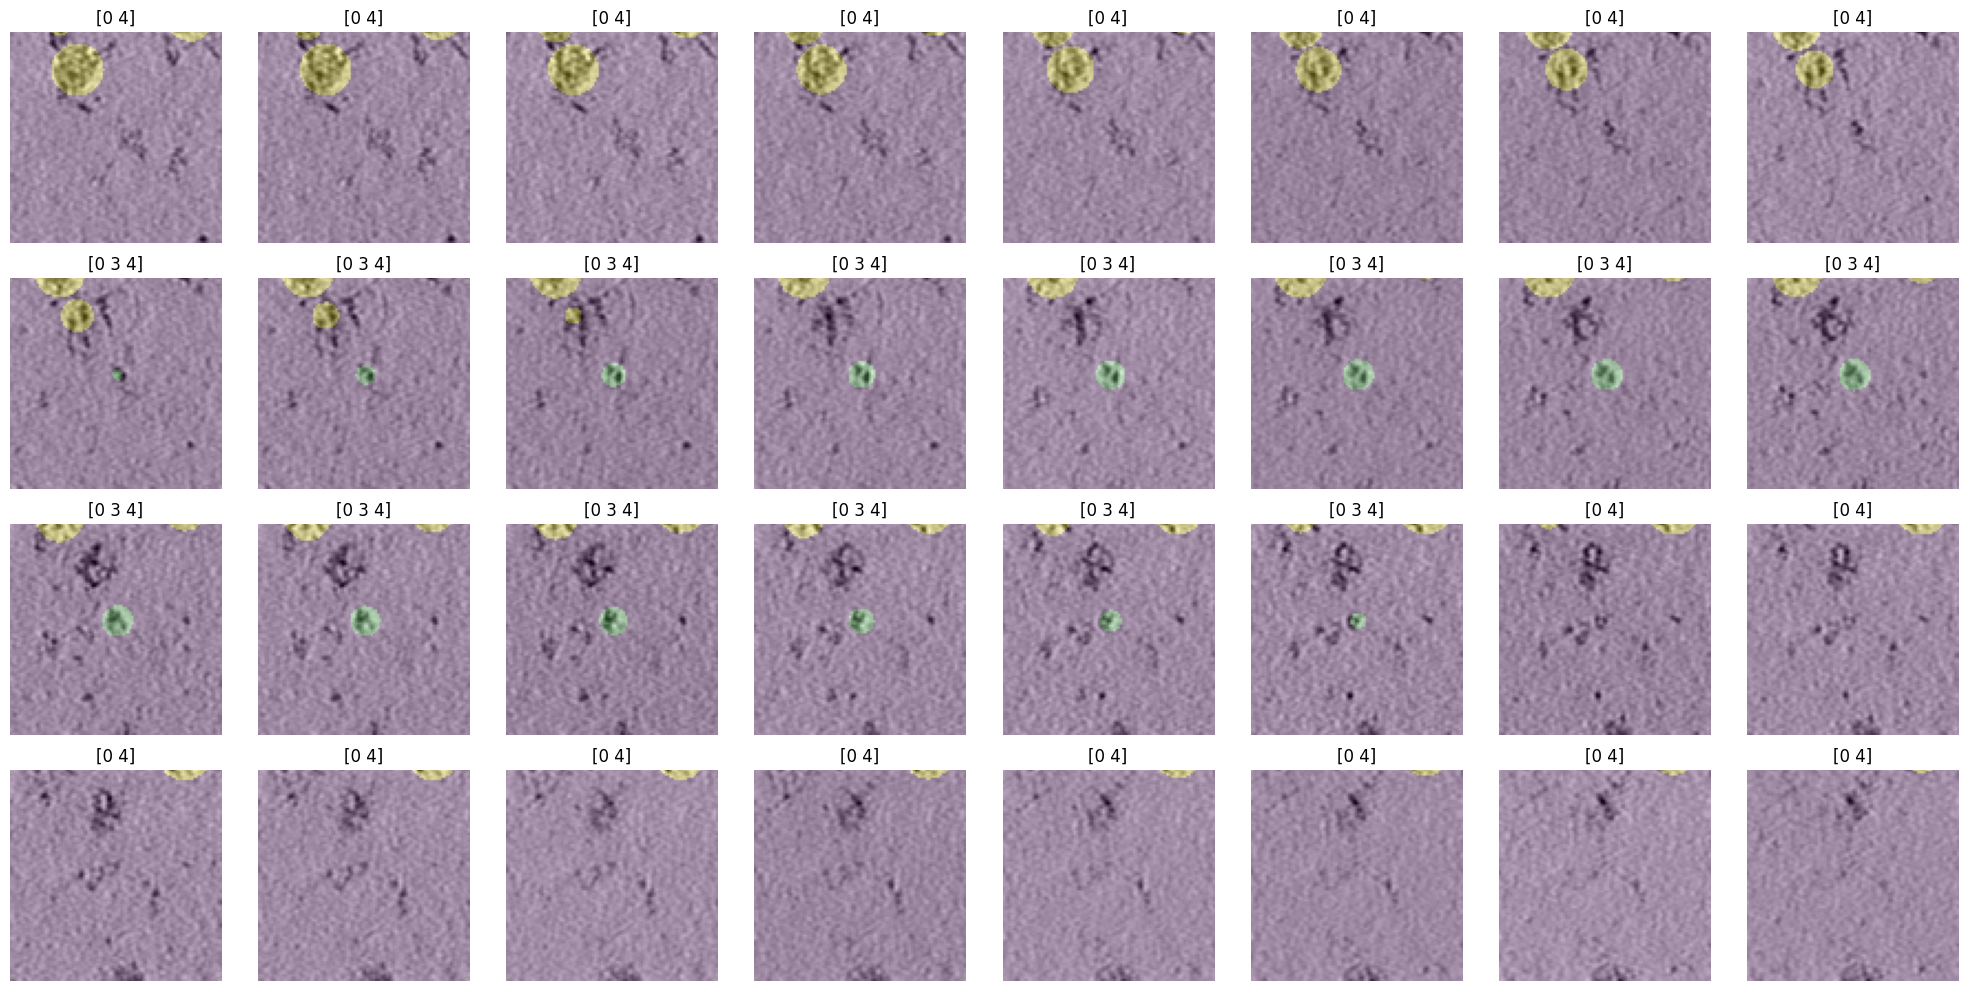

loss_total: 6.147505
loss_box: 0.855416
loss_cls: 0.806069
loss_dfl: 2.775187


In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# ========== 1. 데이터 로드 ==========
batch = next(iter(val_loader))
img = batch["image"]
label = batch["label"]

print(img.shape)
num_b = 18
num_slice = 32
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.flatten()
B, _, D, H, W = img.shape  # 배치 크기, 깊이(D), 높이(H), 너비(W)
stride = 4  # feature map stride
feature_shape = (D // stride, H // stride, W // stride)

# 3D 앵커 생성
anchors_3d = generate_anchors_3d(feature_shape, stride).to(img.device)  # (A,3)
A = anchors_3d.shape[0]
anchors_3d = anchors_3d.unsqueeze(0).expand(B, -1, -1)  # (B, A, 3)

for i in range(num_slice):
    ax = axes[i]
    ax.imshow(img[num_b, 0, i, :, :].cpu().numpy(), cmap='gray')
    ax.imshow(label[num_b, 0, i, :, :].cpu().numpy(), alpha=0.3)
    ax.set_title(f'{np.unique(label[num_b, 0, i, :, :].cpu().numpy())}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# ========== 2. GT 변환 ==========
# GT 변환
gt_spheres, gt_classes = extract_and_convert_3d_bounding_boxes(label, min_size=10, normalize=False)

def pad_gt(gt_spheres, gt_classes, max_g):
    """배치 내 최대 GT 개수를 맞추기 위해 padding 적용"""
    s_list, c_list = [], []
    for b in range(B):
        s_ = gt_spheres[b].to(img.device)
        c_ = gt_classes[b].to(img.device)
        pad_s = torch.zeros((max_g, 4), device=img.device)
        pad_c = torch.zeros((max_g,), device=img.device)
        if s_.shape[0] > 0:
            pad_s[:s_.shape[0]] = s_
            pad_c[:c_.shape[0]] = c_
        s_list.append(pad_s)
        c_list.append(pad_c)
    return torch.stack(s_list, dim=0), torch.stack(c_list, dim=0)

# GT 패딩 적용
max_g = max(x.shape[0] for x in gt_spheres) if len(gt_spheres) else 0
stacked_spheres, stacked_classes = pad_gt(gt_spheres, gt_classes, max_g)

# ========== 2. 모델 예측값 생성 (더미 데이터) ==========
pred_dist = torch.randn(B, A, 4 * 16, device=img.device)  # (-∞, +∞) 범위
pred_dist = (pred_dist - pred_dist.min()) / (pred_dist.max() - pred_dist.min())  # [0,1] 정규화

pred_cls = torch.randn(B, A, 7, device=img.device)  # Binary classification (1 class)

# ========== 3. 손실 함수 계산 ==========
loss_fn = YOLOv8SphereLoss3D_Advanced(num_classes=7, reg_max=16, device=img.device)
loss_dict = loss_fn(pred_dist, pred_cls, anchors_3d, stacked_spheres, stacked_classes)

# ========== 4. 손실 출력 ==========
for key, value in loss_dict.items():
    print(f"{key}: {value.item():.6f}")



# 모델 설정

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegDetect_Unet(
    spatial_dims=3,
    in_channels=1,
    out_channels=n_classes,
    channels=feature_size,
    strides=[2, 2, 2, 1],
    kernel_size=3,
    up_kernel_size=3,
    act=Act.PRELU,
    norm=Norm.INSTANCE,
    dropout=dropout,
    use_det=True,
).to(device)
seg_criterion = CombinedCETverskyLoss(
    lamda=lamda,
    ce_weight=ce_weight,
    n_classes=n_classes,
    class_weights=class_weights,
).to(device)
det_criterion = YOLOv8SphereLoss3D_Advanced(
    num_classes=n_classes, 
    reg_max=reg_max, 
    iou_weight = iou_weight,
    cls_weight = cls_weight,
    dfl_weight = dfl_weight,
    device=device)
pretrain_str = "yes" if use_checkpoint else "no"
weight_str = "weighted" if class_weights is not None else ""

# 모델 이름 설정
model_name = model.__class__.__name__

# 체크포인트 디렉토리 및 파일 설정
checkpoint_base_dir = Path("./model_checkpoints")
folder_name = f"{model_name}_denoiiso_maxf{feature_size[-1]}_{img_depth}x{img_size}x{img_size}_e{num_epochs}_lr{lr}"
checkpoint_dir = checkpoint_base_dir / folder_name
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
# 체크포인트 디렉토리 생성
checkpoint_dir.mkdir(parents=True, exist_ok=True)

if checkpoint_dir.exists():
    best_model_path = checkpoint_dir / 'best_model.pt'
    if best_model_path.exists():
        print(f"기존 best model 발견: {best_model_path}")
        try:
            checkpoint = torch.load(best_model_path, map_location=device)
            # 체크포인트 내부 키 검증
            required_keys = ['model_state_dict', 'optimizer_state_dict', 'epoch', 'best_val_loss']
            if all(k in checkpoint for k in required_keys):
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint['epoch']
                best_val_loss = checkpoint['best_val_loss']
                print("기존 학습된 가중치를 성공적으로 로드했습니다.")
                checkpoint = None
            else:
                raise ValueError("체크포인트 파일에 필요한 key가 없습니다.")
        except Exception as e:
            print(f"체크포인트 파일을 로드하는 중 오류 발생: {e}")

C:\Users\Seungwoo\AppData\Local\Temp\ipykernel_25512\1918560708.py:145: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")
c:\ProgramData\anaconda3\envs\czii\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [10]:
import wandb
from datetime import datetime

current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
run_name = folder_name

# wandb 초기화
wandb.init(
    project='czii_SwinUnetR',  # 프로젝트 이름 설정
    name=run_name,         # 실행(run) 이름 설정
    config={
        'num_epochs': num_epochs,
        'learning_rate': lr,
        'batch_size': batch_size,
        'lambda': lamda,
        "cross_entropy_weight": ce_weight,
        'feature_size': feature_size,
        'img_size': img_size,
        'sampling_ratio': ratios_list,
        'device': device.type,
        "checkpoint_dir": str(checkpoint_dir),
        "class_weights": class_weights.tolist() if class_weights is not None else None,
        "use_checkpoint": use_checkpoint,
        "dropout": dropout,        
        "accumulation_steps": accumulation_steps,
        "num_repeat": num_repeat,
        
        # 필요한 하이퍼파라미터 추가
    }
)
# 모델을 wandb에 연결
wandb.watch(model, log='all')

wandb: Currently logged in as: woow070840 (waooang). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


# 학습

## Scoring

In [11]:
import torch
import torch.nn.functional as F

import torch
import torch.nn.functional as F

def decode_predictions(pred_dist: torch.Tensor, pred_cls: torch.Tensor, pred_conf: torch.Tensor,
                       grid_shape: Tuple[int, int, int], reg_max: int = 16, conf_threshold: float = 0.5):
    """
    YOLO 모델의 예측 결과를 Detection 구(sphere)로 변환합니다.
    
    Args:
        pred_dist (Tensor): (B, A, 4*reg_max) – 각 좌표별 분포 로짓
        pred_cls (Tensor): (B, A, num_classes)
        pred_conf (Tensor): (B, A, 1)
        grid_shape (tuple): (D, H, W) – 원래 feature map의 3D grid shape.
        reg_max (int): 회귀 최대 bin 수
        conf_threshold (float): confidence threshold
        
    Returns:
        List[Tensor]: 각 배치별 Detection 구 (N, 4) → (xc, yc, zc, r)
    """
    B, A, _ = pred_cls.shape
    decoded_spheres = []
    conf_mask = pred_conf.squeeze(-1) > conf_threshold

    grid_D, grid_H, grid_W = grid_shape
    if grid_D * grid_H * grid_W != A:
        raise ValueError(f"grid_shape의 곱({grid_D*grid_H*grid_W})과 A({A})가 일치하지 않습니다.")

    for b in range(B):
        if conf_mask[b].sum() == 0:
            decoded_spheres.append(torch.empty((0, 4), device=pred_cls.device))
            continue

        valid_idxs = conf_mask[b].nonzero(as_tuple=True)[0]  # (n_valid,)
        # 회귀 로짓 -> 확률 분포 -> 기대값 계산
        dist_logits = pred_dist[b, valid_idxs].view(-1, 4, reg_max)  # (n_valid, 4, reg_max)
        dist_prob = F.softmax(dist_logits, dim=-1)
        dist_val = torch.sum(dist_prob * torch.arange(reg_max, device=pred_dist.device, dtype=pred_dist.dtype), dim=-1)  # (n_valid, 4)

        # valid anchor의 원래 grid 상 위치 복원 (flattened index → (z, y, x))
        z_idx = valid_idxs // (grid_H * grid_W)
        rem = valid_idxs % (grid_H * grid_W)
        y_idx = rem // grid_W
        x_idx = rem % grid_W

        # 각 grid cell의 중심 좌표 (정규화: [0,1])
        x = (x_idx.float() + 0.5) / grid_W
        y = (y_idx.float() + 0.5) / grid_H
        z = (z_idx.float() + 0.5) / grid_D

        # 네 번째 회귀값을 반지름으로 사용 (정규화)
        r = dist_val[:, 3] / reg_max

        sphere = torch.stack([x, y, z, r], dim=-1)  # (n_valid, 4)
        decoded_spheres.append(sphere)
    return decoded_spheres

def compute_fbeta_iou(pred_spheres, gt_spheres, beta=2, iou_threshold=0.5):
    """
    F-beta Score 및 mIoU를 계산합니다. (구의 IoU 기반)
    
    Args:
        pred_spheres (Tensor): (N, 4) 예측된 Detection 결과 (xc, yc, zc, r)
        gt_spheres (Tensor): (M, 4) Ground Truth Detection 결과
        beta (float): F-beta Score의 beta 값 (기본값: 2)
        iou_threshold (float): IoU Threshold (기본값: 0.5)
    
    Returns:
        fbeta_score (float): F-beta Score
        mean_iou (float): Mean IoU (mIoU)
    """
    if pred_spheres.shape[0] == 0 or gt_spheres.shape[0] == 0:
        return 0.0, 0.0

    iou_matrix = sphere_iou(pred_spheres, gt_spheres)  # (N, M)

    # 각 예측 구마다 가장 높은 IoU를 가진 GT 구와의 IoU
    max_iou_per_pred, _ = iou_matrix.max(dim=1)
    matched_pred = max_iou_per_pred > iou_threshold
    TP = matched_pred.sum().item()
    FP = pred_spheres.shape[0] - TP
    FN = gt_spheres.shape[0] - TP

    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    fbeta_score = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + 1e-8)

    # IoU가 기준 이상인 예측들에 대해 평균 IoU 계산
    valid_iou = max_iou_per_pred[matched_pred].mean().item() if TP > 0 else 0.0

    return fbeta_score, valid_iou

## processing

In [12]:
import torch

def processing(batch_data, model, seg_criterion, det_criterion, device, det_weight=0.5,reg_max=16, stride=8):
    """
    YOLO 스타일 3D Object Detection을 위한 processing 함수.

    Args:
        batch_data: 
            {
                'image': (B, C, D, H, W),
                'label': (B, 1, D, H, W) → Ground Truth Segmentation 라벨
            }
        model: YOLO Detection 모델
        criterion: YOLOv8SphereLoss3D_Advanced
        device: GPU/CPU
        reg_max: Distance 회귀 파라미터
        stride: 앵커 생성 시 기준 stride

    Returns:
        total_loss, (pred_dist, pred_cls, pred_conf)
    """

    # -----------------------------------------------------------
    # 1) 배치에서 이미지 및 GT 라벨 가져오기
    # -----------------------------------------------------------
    images = batch_data['image'].to(device)  # (B, C, D, H, W)
    labels = batch_data['label'].to(device)  # (B, 1, D, H, W)
    
    B, _, D, H, W = images.shape

    # -----------------------------------------------------------
    # 2) YOLO 모델 추론
    # -----------------------------------------------------------
    x_seg,x_det = model(images)  # (B, 1 + num_classes + 4*reg_max, D, H, W)

    # -----------------------------------------------------------
    # 3) 예측값 분리
    # -----------------------------------------------------------
    num_classes = det_criterion.num_classes  # 클래스 개수
    
    # Confidence Score (B, 1, D, H, W)
    pred_conf = x_det[:, :1, ...]  

    # Class Probabilities (B, num_classes, D, H, W)
    pred_cls = x_det[:, 1:num_classes + 1, ...]

    # Distance Predictions (B, 4 * reg_max, D, H, W) → (cx, cy, cz, r)
    pred_dist = x_det[:, num_classes + 1:, ...]

    # -----------------------------------------------------------
    # 4) YOLO 스타일로 Reshape
    # -----------------------------------------------------------
    A = (D // stride) * (H // stride) * (W // stride)  # 총 앵커 개수

    # Shape 변환 (YOLO 스타일)
    pred_conf = pred_conf.permute(0, 2, 3, 4, 1).reshape(B, -1, 1)  # (B, A, 1)
    pred_cls = pred_cls.permute(0, 2, 3, 4, 1).reshape(B, -1, num_classes)  # (B, A, num_classes)
    pred_dist = pred_dist.permute(0, 2, 3, 4, 1).reshape(B, -1, 4 * reg_max)  # (B, A, 4 * reg_max)

    # Debugging 출력 추가
    # print(f"[DEBUG] pred_conf.shape: {pred_conf.shape}")  # 확인용
    # print(f"[DEBUG] pred_cls.shape: {pred_cls.shape}")
    # print(f"[DEBUG] pred_dist.shape: {pred_dist.shape}")

    # -----------------------------------------------------------
    # 5) 3D 앵커 생성
    # -----------------------------------------------------------
    feature_shape = (D // stride, H // stride, W // stride)
    anchors_3d = generate_anchors_3d(feature_shape, stride).to(device)  # (A, 3)
    anchors_3d = anchors_3d.unsqueeze(0).expand(B, -1, -1)  # (B, A, 3)

    # -----------------------------------------------------------
    # 6) GT 변환 (Segmentation → Bounding Box)
    # -----------------------------------------------------------
    gt_spheres, gt_classes = extract_and_convert_3d_bounding_boxes(labels, min_size=10, normalize=False)

    def pad_gt(gt_spheres, gt_classes, max_g):
        """배치 내 최대 GT 개수를 맞추기 위해 padding 적용"""
        s_list, c_list = [], []
        for b in range(B):
            s_ = gt_spheres[b].to(device)
            c_ = gt_classes[b].to(device)
            pad_s = torch.zeros((max_g, 4), device=device)
            pad_c = torch.zeros((max_g,), device=device)
            if s_.shape[0] > 0:
                pad_s[:s_.shape[0]] = s_
                pad_c[:c_.shape[0]] = c_
            s_list.append(pad_s)
            c_list.append(pad_c)
        return torch.stack(s_list, dim=0), torch.stack(c_list, dim=0)

    # GT 패딩 적용
    max_g = max(x.shape[0] for x in gt_spheres) if len(gt_spheres) else 0
    stacked_spheres, stacked_classes = pad_gt(gt_spheres, gt_classes, max_g)

    # -----------------------------------------------------------
    # 7) YOLO Loss 계산
    # -----------------------------------------------------------
    loss_dict = det_criterion(
        pred_dist=pred_dist,
        pred_cls=pred_cls,
        anchors_3d=anchors_3d,
        gt_spheres=stacked_spheres,
        gt_classes=stacked_classes
    )
    labels = labels.squeeze(1)  # (B, 1, 96, 96, 96) → (B, 96, 96, 96)
    labels = labels.long()  # 라벨을 정수형으로 변환
    # 원핫 인코딩 (B, H, W, D) → (B, num_classes, H, W, D)
    labels = torch.nn.functional.one_hot(labels, num_classes=n_classes)
    labels = labels.permute(0, 4, 1, 2, 3).float()  # (B, num_classes, H, W, D)
    seg_loss = seg_criterion(x_seg, labels)

    # Loss 값 가져오기
    det_loss = loss_dict['loss_total']
    
    # -----------------------------------------------------------
    total_loss = (1-det_weight)*seg_loss + det_weight*det_loss    

    return total_loss, (pred_dist, pred_cls, pred_conf), gt_spheres, gt_classes


def train_one_epoch(model, train_loader, seg_criterion, det_criterion, optimizer, device, epoch, det_weight,accumulation_steps=4):
    """
    한 epoch 동안 모델을 학습하는 함수 (Detection 라벨 기반).
    
    Args:
        model: 학습할 YOLO 3D Detection 모델
        train_loader: DataLoader (Detection 데이터셋 기반)
        criterion: YOLOv8SphereLoss3D_Advanced 손실 함수
        optimizer: 최적화 알고리즘
        device: GPU/CPU 장치
        epoch: 현재 학습 epoch
        accumulation_steps: 그래디언트 누적 스텝 (default: 4)

    Returns:
        평균 학습 손실 (float)
    """
    model.train()
    epoch_loss = 0
    optimizer.zero_grad()  # 그래디언트 초기화

    with tqdm(train_loader, desc=f'Training Epoch {epoch+1}') as pbar:
        for i, batch_data in enumerate(pbar):
            # 손실 계산 (processing 함수 활용)
            total_loss, _, _, _ = processing(batch_data, model, seg_criterion, 
                                             det_criterion,device,det_weight=det_weight, reg_max=det_criterion.reg_max)

            # 그래디언트 누적을 위한 스케일링
            total_loss = total_loss / accumulation_steps  
            total_loss.backward()  # 그래디언트 계산 및 누적
            
            # 그래디언트 업데이트 (accumulation_steps마다 한 번)
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                optimizer.step()  # 파라미터 업데이트
                optimizer.zero_grad()  # 누적된 그래디언트 초기화
            
            # 손실값 누적
            epoch_loss += total_loss.item() * accumulation_steps  # 실제 손실값 반영
            pbar.set_postfix(loss=total_loss.item() * accumulation_steps)  # 현재 손실 출력

    # 에폭 평균 손실 계산
    avg_loss = epoch_loss / len(train_loader)

    # Wandb 로그 기록
    wandb.log({'train_epoch_loss': avg_loss, 'epoch': epoch + 1})

    return avg_loss

def validate_one_epoch(model, val_loader, seg_criterion, det_criterion, device, epoch, 
                       calculate_dice_interval, det_weight, ce_weight, stride: int = 8):
    """
    모델의 한 에폭 검증을 수행하면서, TaskAlignedAssigner3D를 이용하여 
    예측 구와 GT 구의 매칭(foreground assignment)을 수행하고, foreground에 대해 IoU를 측정합니다.
    
    Args:
        model (nn.Module): 학습된 모델 (YOLO 3D Detection + Segmentation)
        val_loader (DataLoader): 검증 데이터 로더
        seg_criterion (nn.Module): Segmentation 손실 함수
        det_criterion (nn.Module): YOLOv8SphereLoss3D_Advanced (Detection 손실 함수, 내부에 assigner 포함)
        device (torch.device): 사용 장치 (GPU/CPU)
        epoch (int): 현재 에폭 번호
        calculate_dice_interval: (추가 평가 지표 계산용, 사용하지 않을 수도 있음)
        det_weight (float): Detection 손실 가중치 (전체 loss 구성 시 사용)
        ce_weight (float): 최종 평가 점수 산출 시 사용 (여기서는 IoU만 측정)
        stride (int): 앵커 생성 시 사용한 stride 값
        
    Returns:
        avg_loss (float): 에폭 평균 손실 값
        mean_iou (float): foreground 할당된 앵커에 대해 계산한 평균 IoU 값
    """
    model.eval()
    total_val_loss = 0.0
    iou_values = []  # 각 foreground 할당에 대해 계산된 IoU 저장

    with torch.no_grad():
        for batch_data in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            # 1) processing() 함수를 통해 모델 추론 및 전체 손실 계산
            total_loss, (pred_dist, pred_cls, pred_conf), gt_spheres , gt_classes = processing(
                batch_data, model, seg_criterion, det_criterion, device,
                det_weight=det_weight, reg_max=det_criterion.reg_max, stride=stride
            )
            total_val_loss += total_loss.item()
            
            # 2) 원본 이미지 크기에서 grid_shape 계산 및 3D 앵커 생성
            B, C, D, H, W = batch_data['image'].shape
            grid_shape = (D // stride, H // stride, W // stride)
            A = grid_shape[0] * grid_shape[1] * grid_shape[2]
            anchors = generate_anchors_3d(grid_shape, stride).to(device)  # (A, 3)
            anchors_3d = anchors.unsqueeze(0).expand(B, -1, -1)            # (B, A, 3)
            
            # 3) pred_dist를 통해 predicted sphere (B, A, 4) 복원
            #    (dist2sphere 함수는 pred_dist와 앵커를 이용해 (x,y,z,r)를 계산)
            pred_sphere = dist2sphere(pred_dist, anchors_3d, det_criterion.reg_max)  # (B, A, 4)
            
            # 4) 배치 내 GT 구와 클래스 리스트를 pad하여 (B, n_max, 4)와 (B, n_max)로 구성
            #    (batch_data 내에 'gt_spheres'와 'gt_classes'가 List[Tensor] 형식으로 있다고 가정)
           
            if len(gt_spheres) == 0:
                # GT가 없는 경우 IoU 0 처리
                continue
            max_g = max(s.shape[0] for s in gt_spheres)
            s_pad_list, c_pad_list = [], []
            for b in range(B):
                s_ = gt_spheres[b].to(device)
                c_ = gt_classes[b].to(device)
                pad_s = torch.zeros((max_g, 4), device=device)
                pad_c = torch.zeros((max_g,), device=device)
                if s_.shape[0] > 0:
                    pad_s[:s_.shape[0]] = s_
                    pad_c[:c_.shape[0]] = c_
                s_pad_list.append(pad_s)
                c_pad_list.append(pad_c)
            stacked_spheres = torch.stack(s_pad_list, dim=0)  # (B, n_max, 4)
            stacked_classes = torch.stack(c_pad_list, dim=0)    # (B, n_max)
            
            # 5) TA3D를 이용하여 예측과 GT 간의 할당을 수행
            assigner = det_criterion.assigner
            fg_mask, target_spheres, target_scores = assigner.assign(
                pd_scores=pred_cls,         # (B, A, num_classes)
                pd_spheres=pred_sphere,     # (B, A, 4)
                anc_points=anchors_3d,      # (B, A, 3) 또는 (A, 3)
                gt_spheres=stacked_spheres, # (B, n_max, 4)
                gt_classes=stacked_classes  # (B, n_max)
            )
            # fg_mask: (B, A) bool tensor, target_spheres: (B, A, 4)
            
            # 6) 각 배치 샘플별로 foreground 할당(anchor)에 대해 예측 구와 할당된 GT 구의 IoU 계산
            for b in range(B):
                fg_indices = fg_mask[b].nonzero(as_tuple=True)[0]  # foreground anchor 인덱스
                if fg_indices.numel() == 0:
                    continue
                # 할당된 GT 구 (target_spheres[b])와 예측 구 (pred_sphere[b])에서 foreground 부분 추출
                pred_fg = pred_sphere[b][fg_indices]    # (n_fg, 4)
                target_fg = target_spheres[b][fg_indices] # (n_fg, 4)
                # 각 쌍에 대해 element-wise IoU 계산: 한 쌍씩 계산
                for i in range(pred_fg.shape[0]):
                    iou_val = sphere_iou(pred_fg[i:i+1], target_fg[i:i+1]).item()
                    iou_values.append(iou_val)
    
    avg_loss = total_val_loss / len(val_loader)
    mean_iou = np.mean(iou_values) if len(iou_values) > 0 else 0.0
    
    wandb.log({
        'val_epoch_loss': avg_loss,
        'val_mean_iou': mean_iou,
        'epoch': epoch + 1
    })
    
    print(f"Validation mean IoU (TA3D assignment): {mean_iou:.4f}")
    return avg_loss, mean_iou

def train_model(
    model, train_loader, val_loader, seg_criterion, det_criterion, optimizer, num_epochs, patience, 
    device, start_epoch, best_val_loss, best_val_fbeta_score, calculate_dice_interval=1,
    det_weight=0.5,
    accumulation_steps=4, pretrained=False
):
    """
    모델을 학습하고 검증하는 함수
    Args:
        model: 학습할 모델
        train_loader: 학습 데이터 로더
        val_loader: 검증 데이터 로더
        criterion: 손실 함수
        optimizer: 최적화 알고리즘
        num_epochs: 총 학습 epoch 수
        patience: early stopping 기준
        device: GPU/CPU 장치
        start_epoch: 시작 epoch
        best_val_loss: 이전 최적 validation loss
        best_val_fbeta_score: 이전 최적 validation f-beta score
        calculate_dice_interval: Dice 점수 계산 주기
    """
    epochs_no_improve = 0

    for epoch in range(start_epoch, num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Train One Epoch
        train_loss = train_one_epoch(
            model=model, 
            train_loader=train_loader, 
            seg_criterion=seg_criterion,
            det_criterion=det_criterion,
            optimizer=optimizer, 
            device=device,
            epoch=epoch,
            det_weight=det_weight,
            accumulation_steps= accumulation_steps
        )
        
        scheduler.step(train_loss)
        # Validate One Epoch
        val_loss, overall_mean_fbeta_score = validate_one_epoch(
            model=model, 
            val_loader=val_loader, 
            seg_criterion=seg_criterion,
            det_criterion=det_criterion,
            device=device, 
            epoch=epoch, 
            calculate_dice_interval=calculate_dice_interval,
            det_weight=det_weight,
            ce_weight=ce_weight
        )

        
        print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation F-beta: {overall_mean_fbeta_score:.4f}")

        if val_loss < best_val_loss and overall_mean_fbeta_score > best_val_fbeta_score:
            best_val_loss = val_loss
            best_val_fbeta_score = overall_mean_fbeta_score
            epochs_no_improve = 0
            if pretrained:
                checkpoint_path = os.path.join(checkpoint_dir, 'best_model_pretrained.pt')
            else:
                checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pt')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'best_val_fbeta_score': best_val_fbeta_score
            }, checkpoint_path)
            print(f"========================================================")
            print(f"SUPER Best model saved. Loss:{best_val_loss:.4f}, Score:{best_val_fbeta_score:.4f}")
            print(f"========================================================")

        # Early stopping 조건 체크
        if val_loss >= best_val_loss and overall_mean_fbeta_score <= best_val_fbeta_score:
            epochs_no_improve += 1
        else:
            epochs_no_improve = 0

        if epochs_no_improve >= patience:
            print("Early stopping")
            checkpoint_path = os.path.join(checkpoint_dir, 'last.pt')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'best_val_fbeta_score': best_val_fbeta_score
            }, checkpoint_path)
            break
        # if epochs_no_improve % 6 == 0 & epochs_no_improve != 0:
        #     # 손실이 개선되지 않았으므로 lambda 감소
        #     new_lamda = max(criterion.lamda - 0.01, 0.35)  # 최소값은 0.1로 설정
        #     criterion.set_lamda(new_lamda)
        #     print(f"Validation loss did not improve. Reducing lambda to {new_lamda:.4f}")

    wandb.finish()


In [13]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    seg_criterion=seg_criterion,
    det_criterion=det_criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    patience=10,
    device=device,
    start_epoch=start_epoch,
    best_val_loss=best_val_loss,
    best_val_fbeta_score=best_val_fbeta_score,
    calculate_dice_interval=1,
    det_weight = det_weight,
    accumulation_steps = accumulation_steps
    )

Epoch 1/4000


Validation Epoch 1: 100%|██████████| 20/20 [01:49<00:00,  5.47s/it]


Validation mean IoU (TA3D assignment): 0.0208


NameError: name 'train_loss' is not defined